# ⚙️ Set Up

In [1]:
# Import Python built-in libraries
import os
import copy
import pickle
import os
import random
import time

In [2]:
# Import pip libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

# Import torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

In [3]:
# Import PyG packages
import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.typing import Adj, OptTensor
import torch_sparse

In [4]:
LOCALE = ''
WINDOW_SIZE = 0

In [5]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.file_name}'
        with open(raw_data_file + "-sessions.pkl", 'rb') as f:
            sessions = pickle.load(f)

        with open(raw_data_file + "-next_items.pkl", 'rb') as f:
            predictions = pickle.load(f)

        with open(raw_data_file + f"-composed_embedding.pkl", 'rb') as f:
            embedding_dict = pickle.load(f)

        data_list = []

        counter = 0

        for session in sessions:
            session, y = session, predictions[counter]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            # Build Data instance
            edge_index = torch.tensor([senders, receivers], dtype=torch.long)
            #x = torch.tensor(uniques, dtype=torch.long)
            x_new = torch.zeros((len(uniques), 100))

            item_counter = 0
            for item in uniques:
                x_new[item_counter] = torch.tensor(embedding_dict[item])
                item_counter += 1

            #y = torch.tensor([y], dtype=torch.long)
            y_new = torch.zeros(1,100)
            y_new[0] = torch.tensor(embedding_dict[y])

            data_list.append(pyg_data.Data(x=x_new, edge_index=edge_index, y=y_new))

            counter += 1

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [6]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, aggr: str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels

        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m, x)
        return x

    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

In [7]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items

        self.gated = GatedSessionGraphConv(self.hidden_size)

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        # (0)
        #embedding = self.embedding(x).squeeze()

        # (1)-(5)
        v_i = self.gated(x, edge_index)

        # Divide nodes by session
        # For the detailed explanation of what is happening below, please refer
        # to the Medium blog post.
        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        # (6)
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        # (7)
        s_l = v_n
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))
        #print("SH: ")
        #print(s_h.shape)
        #print(s_h)


        return s_h

In [8]:
# Define the hyperparameters.
# Code taken from 2021 Fall CS224W Colab assignments.
args = {
    'batch_size': 100,
    'hidden_dim': 100,
    'epochs': 100,
    'l2_penalty': 0.00001,
    'weight_decay': 0.1,
    'step': 30,
    'lr': 0.001,
    'num_items': 466868}

class objectview(object):
    def __init__(self, d): 
        self.__dict__ = d

args = objectview(args)

In [9]:
def train(args, locale):
    # Prepare data pipeline
    train_dataset = GraphDataset('./', locale)
    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       drop_last=True)
    # Build model
    model = SRGNN(args.hidden_dim, args.num_items).to('cuda')

    # Get training components
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args.lr,
                                 weight_decay=args.l2_penalty)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step,
                                          gamma=args.weight_decay)

    #criterion = -F.cosine_similarity( dim=1)

    # Train
    losses = []
    test_accs = []
    top_k_accs = []

    best_acc = 0
    best_model = None

    counter = 1
    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        print(counter)
        counter+=1
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to('cuda')
            optimizer.zero_grad()

            #print(batch.num_graphs)
            pred = model(batch)
            #print(pred.shape)
            #print("PRED: ")
            #print(pred.shape)
            #print(pred)
            label = batch.y
            #print("LABEL: ")
            #print(label.shape)
            #print(label)
            loss = torch.sum(-F.cosine_similarity(pred, label, dim=1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()


    best_model = copy.deepcopy(model)

    return losses, best_model

In [10]:
LOCALES = ['ES','FR','IT']
WINDOW_SIZES = [4,4,4]

Processing...
C:\Users\90539\AppData\Local\Temp\ipykernel_11032\995057356.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  edge_index = torch.tensor([senders, receivers], dtype=torch.long)
Done!
C:\Users\90539\anaconda3\envs\srgnn-env\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


1


100%|██████████| 890/890 [00:34<00:00, 25.44it/s]


2


100%|██████████| 890/890 [00:23<00:00, 38.19it/s]


3


100%|██████████| 890/890 [00:23<00:00, 38.35it/s]


4


100%|██████████| 890/890 [00:28<00:00, 31.77it/s]


5


100%|██████████| 890/890 [00:28<00:00, 31.29it/s]


6


100%|██████████| 890/890 [00:24<00:00, 36.33it/s]


7


100%|██████████| 890/890 [00:24<00:00, 35.96it/s]


8


100%|██████████| 890/890 [00:25<00:00, 35.56it/s]


9


100%|██████████| 890/890 [00:24<00:00, 35.97it/s]


10


100%|██████████| 890/890 [00:25<00:00, 35.51it/s]


11


100%|██████████| 890/890 [00:24<00:00, 35.70it/s]


12


100%|██████████| 890/890 [00:24<00:00, 36.70it/s]


13


100%|██████████| 890/890 [00:25<00:00, 35.17it/s]


14


100%|██████████| 890/890 [00:23<00:00, 38.33it/s]


15


100%|██████████| 890/890 [00:24<00:00, 36.64it/s]


16


100%|██████████| 890/890 [00:24<00:00, 36.70it/s]


17


100%|██████████| 890/890 [00:24<00:00, 36.38it/s]


18


100%|██████████| 890/890 [00:25<00:00, 35.35it/s]


19


100%|██████████| 890/890 [00:23<00:00, 37.18it/s]


20


100%|██████████| 890/890 [00:23<00:00, 38.39it/s]


21


100%|██████████| 890/890 [00:24<00:00, 36.21it/s]


22


100%|██████████| 890/890 [00:24<00:00, 36.63it/s]


23


100%|██████████| 890/890 [00:23<00:00, 38.37it/s]


24


100%|██████████| 890/890 [00:26<00:00, 33.06it/s]


25


100%|██████████| 890/890 [00:24<00:00, 36.29it/s]


26


100%|██████████| 890/890 [00:24<00:00, 36.35it/s]


27


100%|██████████| 890/890 [00:23<00:00, 38.28it/s]


28


100%|██████████| 890/890 [00:23<00:00, 37.29it/s]


29


100%|██████████| 890/890 [00:23<00:00, 37.87it/s]


30


100%|██████████| 890/890 [00:23<00:00, 37.97it/s]


31


100%|██████████| 890/890 [00:23<00:00, 37.77it/s]


32


100%|██████████| 890/890 [00:23<00:00, 38.54it/s]


33


100%|██████████| 890/890 [00:22<00:00, 38.98it/s]


34


100%|██████████| 890/890 [00:23<00:00, 38.06it/s]


35


100%|██████████| 890/890 [00:23<00:00, 38.08it/s]


36


100%|██████████| 890/890 [00:23<00:00, 38.28it/s]


37


100%|██████████| 890/890 [00:23<00:00, 38.04it/s]


38


100%|██████████| 890/890 [00:23<00:00, 38.03it/s]


39


100%|██████████| 890/890 [00:23<00:00, 38.64it/s]


40


100%|██████████| 890/890 [00:23<00:00, 38.28it/s]


41


100%|██████████| 890/890 [00:23<00:00, 37.99it/s]


42


100%|██████████| 890/890 [00:23<00:00, 38.63it/s]


43


100%|██████████| 890/890 [00:23<00:00, 37.69it/s]


44


100%|██████████| 890/890 [00:23<00:00, 37.79it/s]


45


100%|██████████| 890/890 [00:23<00:00, 38.64it/s]


46


100%|██████████| 890/890 [00:22<00:00, 38.78it/s]


47


100%|██████████| 890/890 [00:23<00:00, 38.03it/s]


48


100%|██████████| 890/890 [00:23<00:00, 38.39it/s]


49


100%|██████████| 890/890 [00:23<00:00, 38.08it/s]


50


100%|██████████| 890/890 [00:23<00:00, 37.98it/s]


51


100%|██████████| 890/890 [00:23<00:00, 38.68it/s]


52


100%|██████████| 890/890 [00:23<00:00, 38.37it/s]


53


100%|██████████| 890/890 [00:23<00:00, 38.27it/s]


54


100%|██████████| 890/890 [00:23<00:00, 38.60it/s]


55


100%|██████████| 890/890 [00:23<00:00, 38.45it/s]


56


100%|██████████| 890/890 [00:22<00:00, 38.76it/s]


57


100%|██████████| 890/890 [00:23<00:00, 37.96it/s]


58


100%|██████████| 890/890 [00:23<00:00, 37.99it/s]


59


100%|██████████| 890/890 [00:23<00:00, 38.25it/s]


60


100%|██████████| 890/890 [00:22<00:00, 38.76it/s]


61


100%|██████████| 890/890 [00:23<00:00, 38.63it/s]


62


100%|██████████| 890/890 [00:23<00:00, 38.39it/s]


63


100%|██████████| 890/890 [00:22<00:00, 38.73it/s]


64


100%|██████████| 890/890 [00:23<00:00, 38.37it/s]


65


100%|██████████| 890/890 [00:22<00:00, 38.70it/s]


66


100%|██████████| 890/890 [00:23<00:00, 38.48it/s]


67


100%|██████████| 890/890 [00:23<00:00, 38.67it/s]


68


100%|██████████| 890/890 [00:22<00:00, 38.83it/s]


69


100%|██████████| 890/890 [00:22<00:00, 38.76it/s]


70


100%|██████████| 890/890 [00:22<00:00, 38.82it/s]


71


100%|██████████| 890/890 [00:23<00:00, 38.49it/s]


72


100%|██████████| 890/890 [00:23<00:00, 38.57it/s]


73


100%|██████████| 890/890 [00:22<00:00, 38.92it/s]


74


100%|██████████| 890/890 [00:23<00:00, 38.61it/s]


75


100%|██████████| 890/890 [00:23<00:00, 38.36it/s]


76


100%|██████████| 890/890 [00:23<00:00, 38.37it/s]


77


100%|██████████| 890/890 [00:22<00:00, 38.72it/s]


78


100%|██████████| 890/890 [00:23<00:00, 38.40it/s]


79


100%|██████████| 890/890 [00:23<00:00, 38.59it/s]


80


100%|██████████| 890/890 [00:23<00:00, 38.29it/s]


81


100%|██████████| 890/890 [00:23<00:00, 38.35it/s]


82


100%|██████████| 890/890 [00:22<00:00, 38.88it/s]


83


100%|██████████| 890/890 [00:22<00:00, 38.76it/s]


84


100%|██████████| 890/890 [00:23<00:00, 38.37it/s]


85


100%|██████████| 890/890 [00:23<00:00, 38.22it/s]


86


100%|██████████| 890/890 [00:23<00:00, 38.63it/s]


87


100%|██████████| 890/890 [00:22<00:00, 38.95it/s]


88


100%|██████████| 890/890 [00:22<00:00, 38.86it/s]


89


100%|██████████| 890/890 [00:23<00:00, 38.43it/s]


90


100%|██████████| 890/890 [00:23<00:00, 38.38it/s]


91


100%|██████████| 890/890 [00:23<00:00, 38.53it/s]


92


100%|██████████| 890/890 [00:23<00:00, 37.53it/s]


93


100%|██████████| 890/890 [00:22<00:00, 39.76it/s]


94


100%|██████████| 890/890 [00:22<00:00, 39.13it/s]


95


100%|██████████| 890/890 [00:22<00:00, 39.00it/s]


96


100%|██████████| 890/890 [00:22<00:00, 38.79it/s]


97


100%|██████████| 890/890 [00:22<00:00, 39.09it/s]


98


100%|██████████| 890/890 [00:23<00:00, 38.64it/s]


99


100%|██████████| 890/890 [00:23<00:00, 38.30it/s]


100


100%|██████████| 890/890 [00:22<00:00, 38.90it/s]


Minimum loss: -91.10828818496515


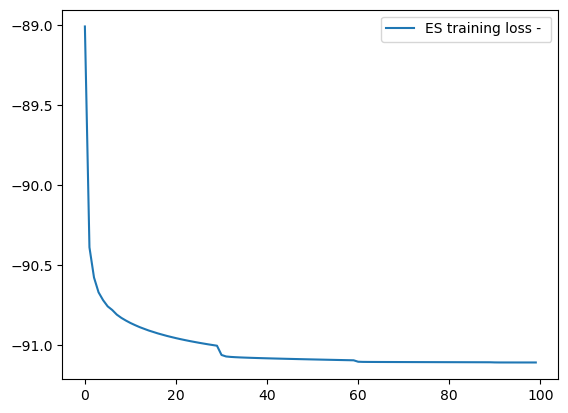

In [11]:
LOCALE = LOCALES[0]
WINDOW_SIZE = WINDOW_SIZES[0]
losses, best_model = train(args, LOCALE)

# Save the best model
torch.save(best_model.state_dict(), f'{LOCALE}model')

print("Minimum loss: {0}".format(min(losses)))

os.remove('processed/pre_filter.pt')
os.remove('processed/pre_transform.pt')

# plt.title(dataset.name)
plt.plot(losses, label="ES training loss" + " - ")
plt.legend()
plt.show()

Processing...
Done!


1


100%|██████████| 1175/1175 [00:43<00:00, 26.88it/s]


2


100%|██████████| 1175/1175 [00:30<00:00, 38.59it/s]


3


100%|██████████| 1175/1175 [00:30<00:00, 38.71it/s]


4


100%|██████████| 1175/1175 [00:30<00:00, 38.15it/s]


5


100%|██████████| 1175/1175 [00:30<00:00, 38.52it/s]


6


100%|██████████| 1175/1175 [00:30<00:00, 38.38it/s]


7


100%|██████████| 1175/1175 [00:30<00:00, 38.76it/s]


8


100%|██████████| 1175/1175 [00:30<00:00, 38.33it/s]


9


100%|██████████| 1175/1175 [00:30<00:00, 38.28it/s]


10


100%|██████████| 1175/1175 [00:30<00:00, 38.31it/s]


11


100%|██████████| 1175/1175 [00:30<00:00, 38.66it/s]


12


100%|██████████| 1175/1175 [00:30<00:00, 38.53it/s]


13


100%|██████████| 1175/1175 [00:30<00:00, 38.14it/s]


14


100%|██████████| 1175/1175 [00:30<00:00, 38.69it/s]


15


100%|██████████| 1175/1175 [00:30<00:00, 38.56it/s]


16


100%|██████████| 1175/1175 [00:30<00:00, 38.66it/s]


17


100%|██████████| 1175/1175 [00:30<00:00, 38.12it/s]


18


100%|██████████| 1175/1175 [00:30<00:00, 38.58it/s]


19


100%|██████████| 1175/1175 [00:30<00:00, 38.37it/s]


20


100%|██████████| 1175/1175 [00:31<00:00, 37.77it/s]


21


100%|██████████| 1175/1175 [00:31<00:00, 37.86it/s]


22


100%|██████████| 1175/1175 [00:31<00:00, 37.60it/s]


23


100%|██████████| 1175/1175 [00:31<00:00, 37.55it/s]


24


100%|██████████| 1175/1175 [00:31<00:00, 37.77it/s]


25


100%|██████████| 1175/1175 [00:31<00:00, 37.71it/s]


26


100%|██████████| 1175/1175 [00:31<00:00, 37.47it/s]


27


100%|██████████| 1175/1175 [00:31<00:00, 37.85it/s]


28


100%|██████████| 1175/1175 [00:31<00:00, 37.70it/s]


29


100%|██████████| 1175/1175 [00:31<00:00, 37.85it/s]


30


100%|██████████| 1175/1175 [00:31<00:00, 37.40it/s]


31


100%|██████████| 1175/1175 [00:31<00:00, 37.89it/s]


32


100%|██████████| 1175/1175 [00:31<00:00, 37.65it/s]


33


100%|██████████| 1175/1175 [00:31<00:00, 37.85it/s]


34


100%|██████████| 1175/1175 [00:31<00:00, 37.50it/s]


35


100%|██████████| 1175/1175 [00:31<00:00, 37.24it/s]


36


100%|██████████| 1175/1175 [00:30<00:00, 38.53it/s]


37


100%|██████████| 1175/1175 [00:30<00:00, 38.72it/s]


38


100%|██████████| 1175/1175 [00:30<00:00, 38.76it/s]


39


100%|██████████| 1175/1175 [00:30<00:00, 38.21it/s]


40


100%|██████████| 1175/1175 [00:31<00:00, 37.50it/s]


41


100%|██████████| 1175/1175 [00:31<00:00, 37.68it/s]


42


100%|██████████| 1175/1175 [00:31<00:00, 37.57it/s]


43


100%|██████████| 1175/1175 [00:31<00:00, 36.94it/s]


44


100%|██████████| 1175/1175 [00:31<00:00, 37.72it/s]


45


100%|██████████| 1175/1175 [00:31<00:00, 37.34it/s]


46


100%|██████████| 1175/1175 [00:31<00:00, 37.20it/s]


47


100%|██████████| 1175/1175 [00:31<00:00, 37.46it/s]


48


100%|██████████| 1175/1175 [00:31<00:00, 37.04it/s]


49


100%|██████████| 1175/1175 [00:31<00:00, 37.22it/s]


50


100%|██████████| 1175/1175 [00:31<00:00, 37.50it/s]


51


100%|██████████| 1175/1175 [00:31<00:00, 37.40it/s]


52


100%|██████████| 1175/1175 [00:31<00:00, 37.00it/s]


53


100%|██████████| 1175/1175 [00:31<00:00, 37.51it/s]


54


100%|██████████| 1175/1175 [00:31<00:00, 37.49it/s]


55


100%|██████████| 1175/1175 [00:31<00:00, 37.76it/s]


56


100%|██████████| 1175/1175 [00:31<00:00, 37.57it/s]


57


100%|██████████| 1175/1175 [00:31<00:00, 37.80it/s]


58


100%|██████████| 1175/1175 [00:30<00:00, 38.04it/s]


59


100%|██████████| 1175/1175 [00:31<00:00, 37.69it/s]


60


100%|██████████| 1175/1175 [00:31<00:00, 37.85it/s]


61


100%|██████████| 1175/1175 [00:31<00:00, 37.37it/s]


62


100%|██████████| 1175/1175 [00:31<00:00, 37.72it/s]


63


100%|██████████| 1175/1175 [00:31<00:00, 37.75it/s]


64


100%|██████████| 1175/1175 [00:31<00:00, 37.63it/s]


65


100%|██████████| 1175/1175 [00:31<00:00, 37.49it/s]


66


100%|██████████| 1175/1175 [00:31<00:00, 37.74it/s]


67


100%|██████████| 1175/1175 [00:31<00:00, 37.88it/s]


68


100%|██████████| 1175/1175 [00:31<00:00, 37.66it/s]


69


100%|██████████| 1175/1175 [00:31<00:00, 37.76it/s]


70


100%|██████████| 1175/1175 [00:31<00:00, 37.27it/s]


71


100%|██████████| 1175/1175 [00:31<00:00, 37.23it/s]


72


100%|██████████| 1175/1175 [00:31<00:00, 37.63it/s]


73


100%|██████████| 1175/1175 [00:32<00:00, 35.90it/s]


74


100%|██████████| 1175/1175 [00:32<00:00, 35.67it/s]


75


100%|██████████| 1175/1175 [00:31<00:00, 37.85it/s]


76


100%|██████████| 1175/1175 [00:30<00:00, 38.34it/s]


77


100%|██████████| 1175/1175 [00:30<00:00, 38.22it/s]


78


100%|██████████| 1175/1175 [00:31<00:00, 37.39it/s]


79


100%|██████████| 1175/1175 [00:31<00:00, 36.77it/s]


80


100%|██████████| 1175/1175 [00:31<00:00, 37.44it/s]


81


100%|██████████| 1175/1175 [00:31<00:00, 37.43it/s]


82


100%|██████████| 1175/1175 [00:32<00:00, 36.59it/s]


83


100%|██████████| 1175/1175 [00:32<00:00, 36.51it/s]


84


100%|██████████| 1175/1175 [00:31<00:00, 37.37it/s]


85


100%|██████████| 1175/1175 [00:31<00:00, 37.61it/s]


86


100%|██████████| 1175/1175 [00:31<00:00, 36.83it/s]


87


100%|██████████| 1175/1175 [00:32<00:00, 36.38it/s]


88


100%|██████████| 1175/1175 [00:31<00:00, 37.25it/s]


89


100%|██████████| 1175/1175 [00:31<00:00, 37.29it/s]


90


100%|██████████| 1175/1175 [00:32<00:00, 35.91it/s]


91


100%|██████████| 1175/1175 [00:32<00:00, 36.09it/s]


92


100%|██████████| 1175/1175 [00:31<00:00, 36.80it/s]


93


100%|██████████| 1175/1175 [00:31<00:00, 37.12it/s]


94


100%|██████████| 1175/1175 [00:32<00:00, 36.40it/s]


95


100%|██████████| 1175/1175 [00:31<00:00, 37.02it/s]


96


100%|██████████| 1175/1175 [00:32<00:00, 36.46it/s]


97


100%|██████████| 1175/1175 [00:31<00:00, 37.23it/s]


98


100%|██████████| 1175/1175 [00:31<00:00, 36.96it/s]


99


100%|██████████| 1175/1175 [00:31<00:00, 37.02it/s]


100


100%|██████████| 1175/1175 [00:32<00:00, 36.44it/s]


Minimum loss: -92.89584070333325


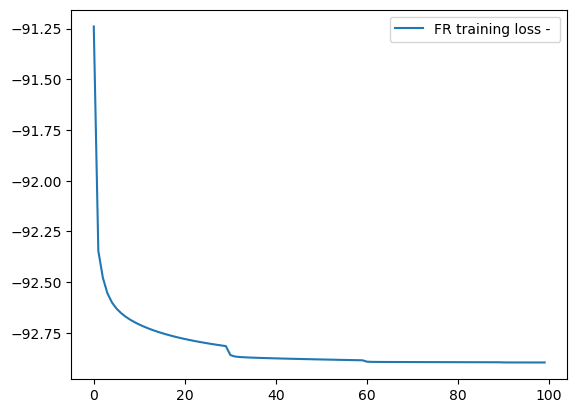

In [12]:
LOCALE = LOCALES[1]
WINDOW_SIZE = WINDOW_SIZES[1]
losses, best_model = train(args, LOCALE)

# Save the best model
torch.save(best_model.state_dict(), f'{LOCALE}model')

print("Minimum loss: {0}".format(min(losses)))

os.remove('processed/pre_filter.pt')
os.remove('processed/pre_transform.pt')

# plt.title(dataset.name)
plt.plot(losses, label="FR training loss" + " - ")
plt.legend()
plt.show()

In [13]:
LOCALE = LOCALES[2]
WINDOW_SIZE = WINDOW_SIZES[2]
losses, best_model = train(args, LOCALE)

# Save the best model
torch.save(best_model.state_dict(), f'{LOCALE}model')

print("Minimum loss: {0}".format(min(losses)))

os.remove('processed/pre_filter.pt')
os.remove('processed/pre_transform.pt')

# plt.title(dataset.name)
plt.plot(losses, label="IT training loss" + " - ")
plt.legend()
plt.show()

Processing...
Done!


1


100%|██████████| 1269/1269 [00:46<00:00, 27.23it/s]


2


100%|██████████| 1269/1269 [00:34<00:00, 36.82it/s]


3


100%|██████████| 1269/1269 [00:34<00:00, 36.28it/s]


4


100%|██████████| 1269/1269 [00:34<00:00, 36.96it/s]


5


100%|██████████| 1269/1269 [00:33<00:00, 38.16it/s]


6


100%|██████████| 1269/1269 [00:34<00:00, 36.88it/s]


7


100%|██████████| 1269/1269 [00:33<00:00, 38.07it/s]


8


100%|██████████| 1269/1269 [00:34<00:00, 37.16it/s]


9


100%|██████████| 1269/1269 [00:34<00:00, 36.73it/s]


10


100%|██████████| 1269/1269 [00:34<00:00, 36.43it/s]


11


100%|██████████| 1269/1269 [00:34<00:00, 37.01it/s]


12


100%|██████████| 1269/1269 [00:34<00:00, 36.43it/s]


13


100%|██████████| 1269/1269 [00:35<00:00, 35.55it/s]


14


100%|██████████| 1269/1269 [00:39<00:00, 32.07it/s]


15


100%|██████████| 1269/1269 [00:36<00:00, 34.40it/s]


16


100%|██████████| 1269/1269 [00:36<00:00, 34.95it/s]


17


100%|██████████| 1269/1269 [00:35<00:00, 36.09it/s]


18


100%|██████████| 1269/1269 [00:33<00:00, 37.42it/s]


19


100%|██████████| 1269/1269 [00:35<00:00, 35.89it/s]


20


100%|██████████| 1269/1269 [00:34<00:00, 37.09it/s]


21


100%|██████████| 1269/1269 [00:35<00:00, 35.79it/s]


22


100%|██████████| 1269/1269 [00:35<00:00, 35.76it/s]


23


100%|██████████| 1269/1269 [00:36<00:00, 35.04it/s]


24


100%|██████████| 1269/1269 [00:36<00:00, 35.24it/s]


25


100%|██████████| 1269/1269 [00:35<00:00, 36.05it/s]


26


100%|██████████| 1269/1269 [00:35<00:00, 35.35it/s]


27


100%|██████████| 1269/1269 [00:35<00:00, 36.07it/s]


28


100%|██████████| 1269/1269 [00:35<00:00, 35.99it/s]


29


100%|██████████| 1269/1269 [00:34<00:00, 37.08it/s]


30


100%|██████████| 1269/1269 [00:34<00:00, 37.12it/s]


31


100%|██████████| 1269/1269 [00:34<00:00, 36.65it/s]


32


100%|██████████| 1269/1269 [00:34<00:00, 36.65it/s]


33


100%|██████████| 1269/1269 [00:33<00:00, 37.42it/s]


34


100%|██████████| 1269/1269 [00:35<00:00, 35.66it/s]


35


100%|██████████| 1269/1269 [00:34<00:00, 36.42it/s]


36


100%|██████████| 1269/1269 [00:35<00:00, 35.99it/s]


37


100%|██████████| 1269/1269 [00:34<00:00, 36.58it/s]


38


100%|██████████| 1269/1269 [00:34<00:00, 36.37it/s]


39


100%|██████████| 1269/1269 [00:34<00:00, 36.66it/s]


40


100%|██████████| 1269/1269 [00:34<00:00, 36.52it/s]


41


100%|██████████| 1269/1269 [00:35<00:00, 36.23it/s]


42


100%|██████████| 1269/1269 [00:35<00:00, 35.56it/s]


43


100%|██████████| 1269/1269 [00:36<00:00, 35.19it/s]


44


100%|██████████| 1269/1269 [00:35<00:00, 35.56it/s]


45


100%|██████████| 1269/1269 [00:36<00:00, 34.77it/s]


46


100%|██████████| 1269/1269 [00:35<00:00, 35.45it/s]


47


100%|██████████| 1269/1269 [00:36<00:00, 35.10it/s]


48


100%|██████████| 1269/1269 [00:36<00:00, 35.18it/s]


49


100%|██████████| 1269/1269 [00:36<00:00, 34.75it/s]


50


100%|██████████| 1269/1269 [00:35<00:00, 35.37it/s]


51


100%|██████████| 1269/1269 [00:35<00:00, 35.60it/s]


52


100%|██████████| 1269/1269 [00:34<00:00, 36.49it/s]


53


100%|██████████| 1269/1269 [00:35<00:00, 35.91it/s]


54


100%|██████████| 1269/1269 [00:34<00:00, 36.56it/s]


55


100%|██████████| 1269/1269 [00:35<00:00, 36.23it/s]


56


100%|██████████| 1269/1269 [00:34<00:00, 36.52it/s]


57


100%|██████████| 1269/1269 [00:34<00:00, 36.88it/s]


58


100%|██████████| 1269/1269 [00:34<00:00, 36.49it/s]


59


100%|██████████| 1269/1269 [00:34<00:00, 36.81it/s]


60


100%|██████████| 1269/1269 [00:34<00:00, 37.00it/s]


61


100%|██████████| 1269/1269 [00:34<00:00, 36.82it/s]


62


100%|██████████| 1269/1269 [00:35<00:00, 35.29it/s]


63


100%|██████████| 1269/1269 [00:35<00:00, 35.56it/s]


64


100%|██████████| 1269/1269 [00:36<00:00, 35.25it/s]


65


100%|██████████| 1269/1269 [00:37<00:00, 33.86it/s]


66


100%|██████████| 1269/1269 [00:39<00:00, 31.94it/s]


67


100%|██████████| 1269/1269 [00:38<00:00, 33.05it/s]


68


100%|██████████| 1269/1269 [00:35<00:00, 35.66it/s]


69


100%|██████████| 1269/1269 [00:35<00:00, 35.47it/s]


70


100%|██████████| 1269/1269 [00:38<00:00, 32.61it/s]


71


100%|██████████| 1269/1269 [00:38<00:00, 33.39it/s]


72


100%|██████████| 1269/1269 [00:37<00:00, 33.71it/s]


73


100%|██████████| 1269/1269 [00:37<00:00, 33.60it/s]


74


100%|██████████| 1269/1269 [00:37<00:00, 33.45it/s]


75


100%|██████████| 1269/1269 [00:38<00:00, 33.01it/s]


76


100%|██████████| 1269/1269 [00:38<00:00, 33.30it/s]


77


 28%|██▊       | 352/1269 [00:10<00:27, 32.83it/s]